In [1]:
# Cell 0 — imports & helpers
import os, re, textwrap, datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

mpl.rcParams.update({
    "font.family": "DejaVu Sans",
    "axes.unicode_minus": True,
})

DATA_CSV   = "financial_news_events.csv"
SAVE_DIR   = Path("figs"); SAVE_DIR.mkdir(exist_ok=True, parents=True)
BRIEF_DIR  = Path("ai_briefs"); BRIEF_DIR.mkdir(exist_ok=True, parents=True)

SMOOTH_WIN = 3      # smoothing window for sentiment (days)
ROLL_WIN   = 21     # rolling correlation window (days)
MIN_N      = 10     # min samples for stats
TOP_K      = 6      # plot top-K indices by coverage

SENT_VAL = {"Negative": -1.0, "Neutral": 0.0, "Positive": 1.0}
IMPACT_W = {"High": 1.0, "Medium": 0.6, "Low": 0.3}

def _safe(s: str) -> str:
    return re.sub(r"[^a-zA-Z0-9_.-]+", "_", str(s))

def _star(p):
    if pd.isna(p): return ""
    return "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "·" if p < 0.10 else ""

def _has_openai_key() -> bool:
    return bool(os.environ.get("OPENAI_API_KEY"))

print("✅ Helpers ready.")


✅ Helpers ready.


In [2]:
# Cell 1 — load & daily aggregation (sentiment ↔ market)
assert os.path.exists(DATA_CSV), f"Cannot find {DATA_CSV}"

df = pd.read_csv(DATA_CSV)

# 标准化列名（大小写/空格）
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

need_cols = ["date","headline","market_index","index_change_percent","sentiment","impact_level","trading_volume"]
missing = [c for c in need_cols if c not in df.columns]
if missing:
    print("⚠️ Missing columns:", missing)

# 时间
df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True).dt.normalize()
df = df.dropna(subset=["date"]).copy()

# 指数缺失填 ALL
if "market_index" not in df.columns:
    df["market_index"] = "ALL"
df["market_index"] = df["market_index"].fillna("ALL").astype(str)

# 现成情绪 → 数值 + 权重
df["label"] = df.get("sentiment","Neutral").astype(str).str.title().map({"Negative":"Negative","Neutral":"Neutral","Positive":"Positive"})
df["val"]   = df["label"].map(SENT_VAL).fillna(0.0)
df["w"]     = df.get("impact_level","Medium").map(IMPACT_W).fillna(0.6)

# 置信度列如果没有就赋默认 0.6
conf_col = "conf_from_source"
if conf_col not in df.columns:
    df[conf_col] = 0.6
df["conf"]  = pd.to_numeric(df[conf_col], errors="coerce").fillna(0.6).clip(0,1)

# 综合情绪分数
df["score"] = df["val"] * df["w"] * df["conf"]

# 市场收益（百分比 → 小数）
df["ret"] = pd.to_numeric(df.get("index_change_percent", np.nan), errors="coerce")
if df["ret"].abs().max(skipna=True) and df["ret"].abs().max() > 1.0:
    df["ret"] = df["ret"] / 100.0

# 日度聚合（index × date）
daily = (
    df.groupby(["market_index","date"])
      .agg(sent_index=("score","mean"),
           sent_n=("score","size"),
           mkt_ret=("ret","mean"),
           volume=("trading_volume","mean"))
      .reset_index()
      .sort_values(["market_index","date"])
)

# 平滑、次日收益与累计指数
daily["sent_smooth"] = daily.groupby("market_index")["sent_index"]\
                            .transform(lambda s: s.rolling(SMOOTH_WIN, min_periods=1).mean())
daily["mkt_ret_fwd"] = daily.groupby("market_index")["mkt_ret"].shift(-1)
daily["cum_index"]   = daily.groupby("market_index")["mkt_ret"]\
                            .transform(lambda r: (1.0 + r.fillna(0.0)).cumprod()*100.0)

# 便于同轴对比的 z-score
for col in ["sent_smooth","cum_index"]:
    daily[col+"_z"] = daily.groupby("market_index")[col].transform(
        lambda s: (s - s.mean()) / (s.std(ddof=0) if s.std(ddof=0) != 0 else 1.0)
    )

daily.to_csv("sentiment_daily_infile.csv", index=False, encoding="utf-8-sig")
print(f"✅ Saved: sentiment_daily_infile.csv (rows={len(daily)})")
daily.head()

✅ Saved: sentiment_daily_infile.csv (rows=2030)


,market_index,date,sent_index,sent_n,mkt_ret,volume,sent_smooth,mkt_ret_fwd,cum_index,sent_smooth_z,cum_index_z
0,ASX 200,2025-02-01 00:00:00+00:00,0.00,1,0.03420,377.30,0.00,0.00825,103.420000,0.094534,-0.446941
1,ASX 200,2025-02-02 00:00:00+00:00,0.12,2,0.00825,271.37,0.06,0.03250,104.273215,0.447305,-0.385410
2,ASX 200,2025-02-03 00:00:00+00:00,0.00,1,0.03250,298.77,0.04,-0.01760,107.662094,0.329715,-0.141013
3,ASX 200,2025-02-05 00:00:00+00:00,-0.36,1,-0.01760,180.51,-0.08,0.03250,105.767242,-0.375829,-0.277664
4,ASX 200,2025-02-06 00:00:00+00:00,0.00,1,0.03250,498.04,-0.12,0.02225,109.204677,-0.611010,-0.029766


✅ Saved: correlation_summary.csv


,Index,N (t→t+1),Pearson (t→t+1),p (t→t+1),Spearman (t→t+1),p_s (t→t+1),N (t→t),Pearson (t→t),p (t→t),Spearman (t→t),p_s (t→t),Pearson± (t→t+1),Spearman± (t→t+1)
2,CAC 40,101,0.098,0.330,0.073,0.469,102,0.010,0.920,0.033,0.744,+0.098,+0.073
16,Shanghai Composite,120,0.087,0.347,0.039,0.674,121,0.150,0.100,0.104,0.255,+0.087,+0.039
1,BSE Sensex,100,0.077,0.449,0.090,0.374,101,-0.118,0.239,-0.040,0.694,+0.077,+0.090
11,Nasdaq Composite,111,0.060,0.535,0.047,0.627,112,0.078,0.414,0.066,0.488,+0.060,+0.047
4,Dow Jones,118,0.054,0.560,0.042,0.653,119,0.120,0.192,0.123,0.182,+0.054,+0.042
14,S&P 500,120,0.031,0.735,0.031,0.740,121,0.059,0.522,0.094,0.306,+0.031,+0.031
6,FTSE 100,94,0.030,0.772,0.025,0.814,95,0.093,0.370,0.034,0.744,+0.030,+0.025
12,Nikkei 225,108,0.028,0.774,-0.031,0.749,109,0.028,0.774,0.015,0.877,+0.028,-0.031
13,Russell 2000,113,0.004,0.966,-0.019,0.838,114,0.111,0.242,0.103,0.275,+0.004,-0.019
17,TSX,117,-0.009,0.919,-0.014,0.878,118,-0.068,0.463,-0.022,0.813,-0.009,-0.014


📌 Will plot for indices: ['Shanghai Composite', 'S&P 500', 'Dow Jones', 'Hang Seng', 'TSX', 'Russell 2000']


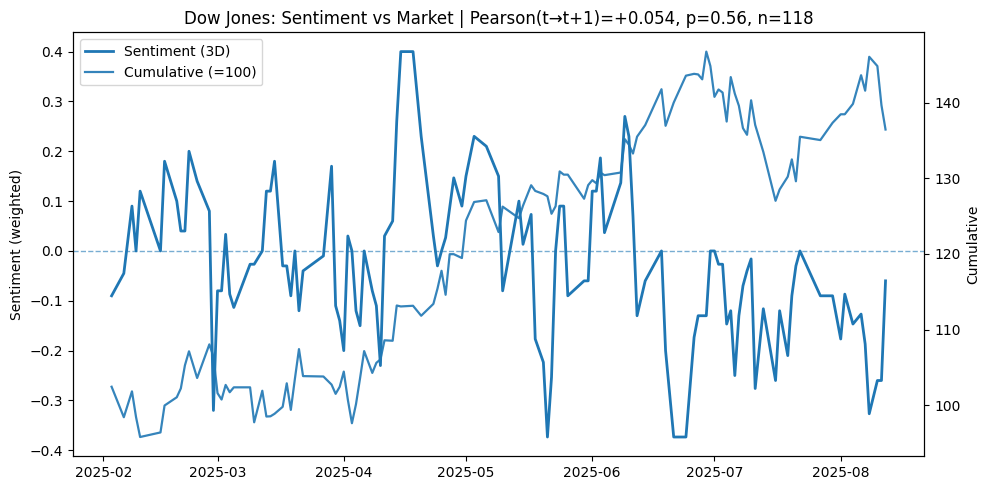

  → saved: figs/sent_vs_market_Dow_Jones.png


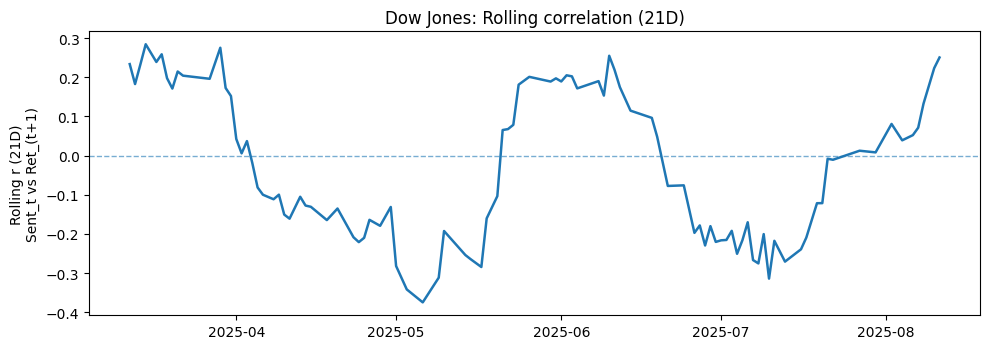

  → saved: figs/rolling_corr_Dow_Jones.png


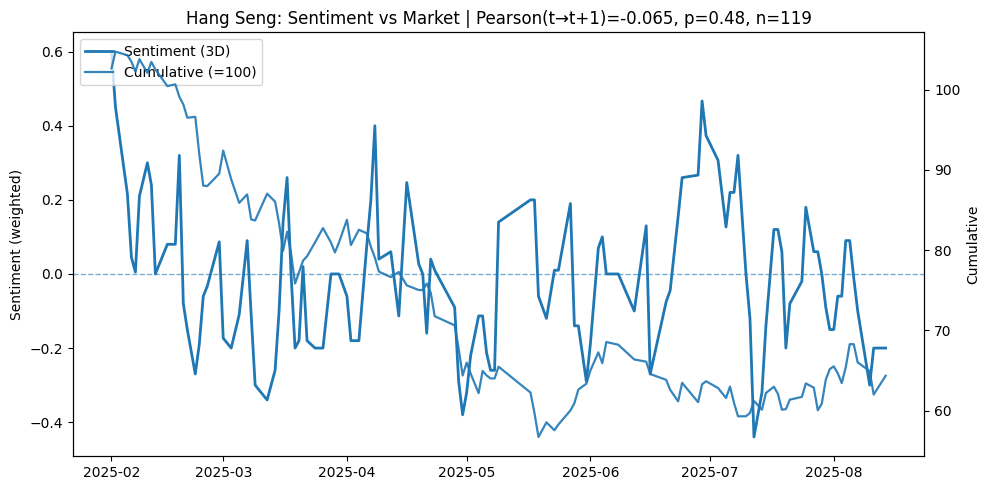

  → saved: figs/sent_vs_market_Hang_Seng.png


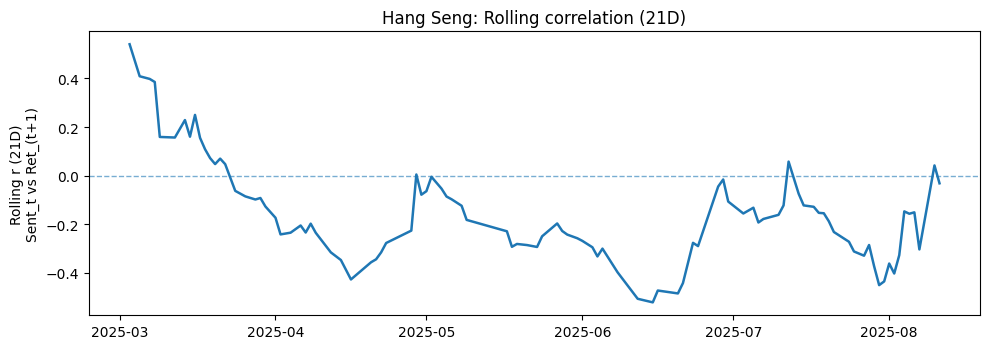

  → saved: figs/rolling_corr_Hang_Seng.png


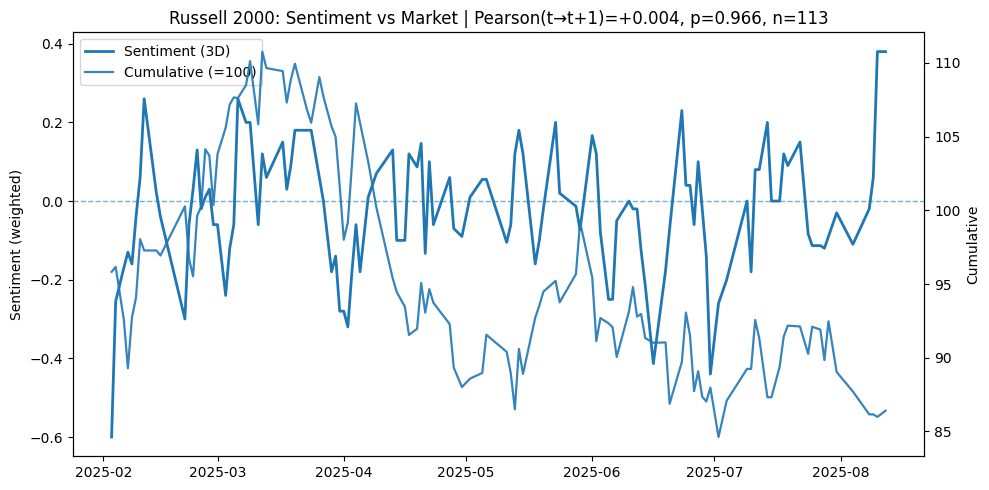

  → saved: figs/sent_vs_market_Russell_2000.png


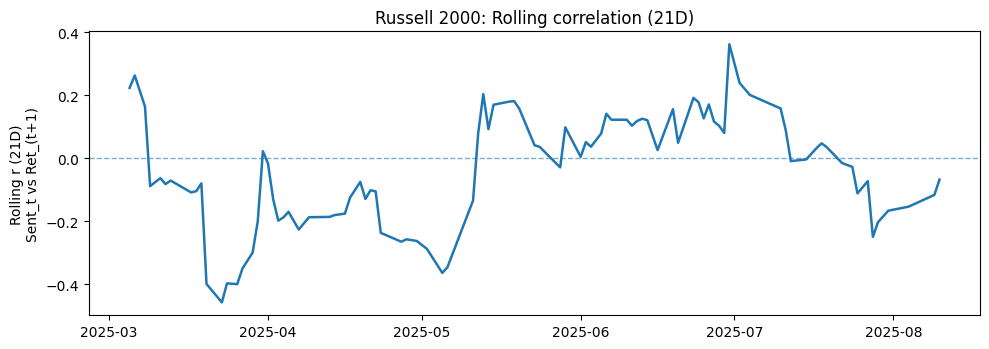

  → saved: figs/rolling_corr_Russell_2000.png


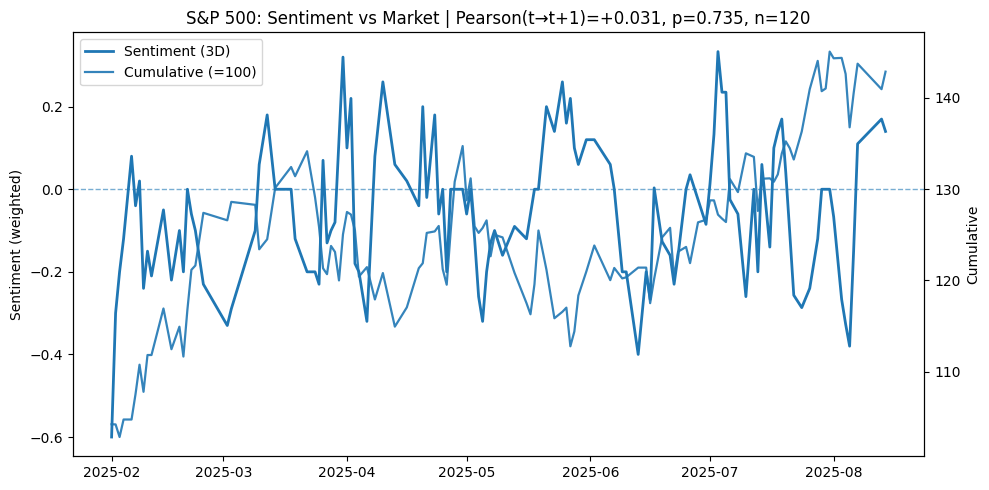

  → saved: figs/sent_vs_market_S_P_500.png


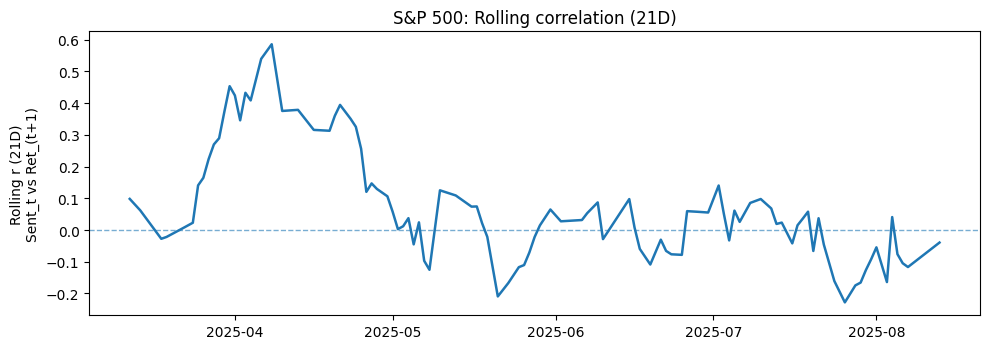

  → saved: figs/rolling_corr_S_P_500.png


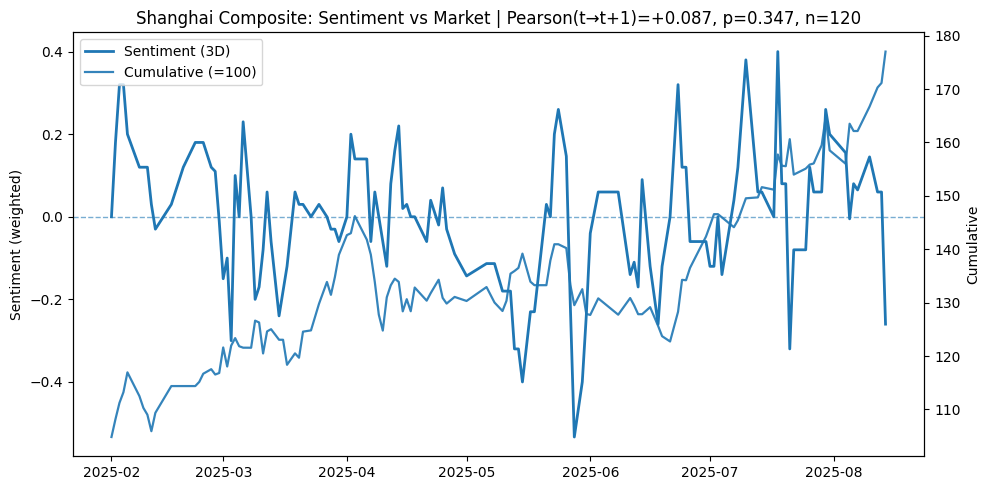

  → saved: figs/sent_vs_market_Shanghai_Composite.png


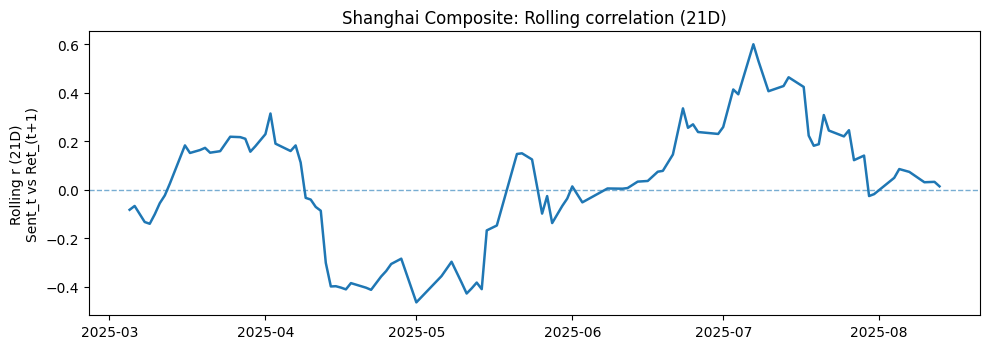

  → saved: figs/rolling_corr_Shanghai_Composite.png


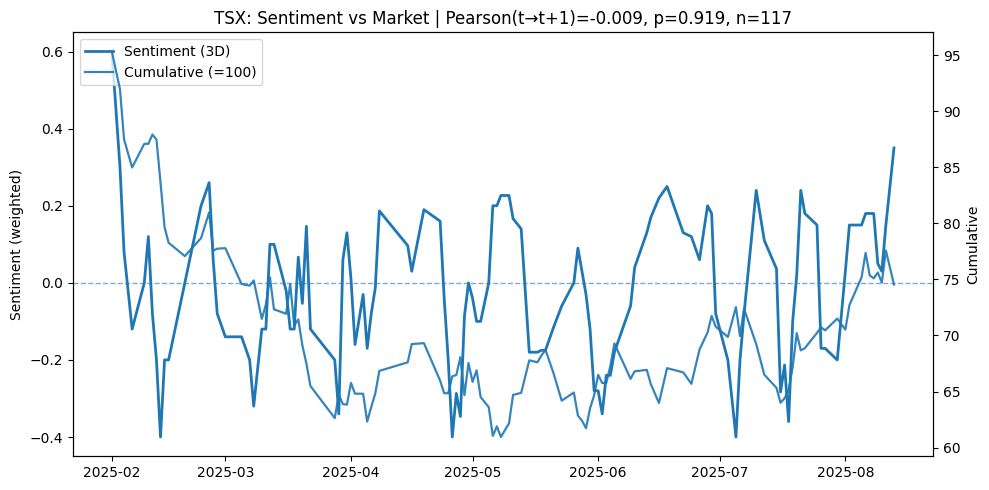

  → saved: figs/sent_vs_market_TSX.png


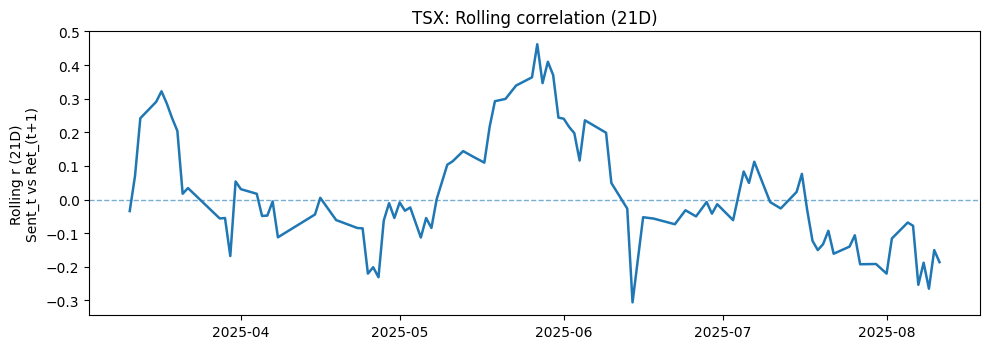

  → saved: figs/rolling_corr_TSX.png


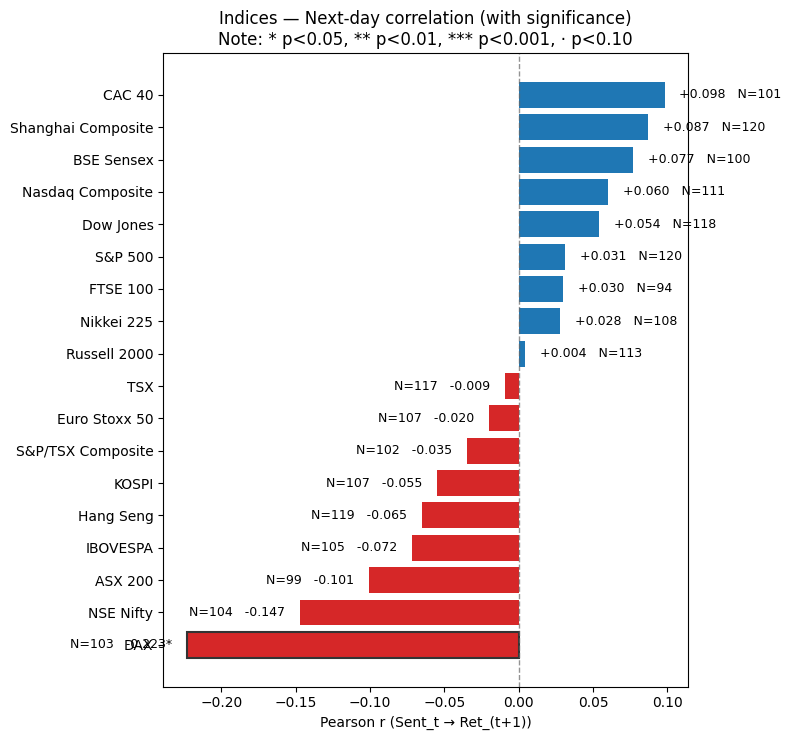

✅ Saved: figs/corr_bar_with_stars.png
✅ Saved: trend_summary.csv


,Index,N_total,Pearson_all,p_all,RollWin,r_roll_mean,r_roll_median,r_roll_pos_share
2,CAC 40,101,0.098,0.330,21,0.039,0.055,0.475
16,Shanghai Composite,120,0.087,0.347,21,0.023,0.035,0.492
1,BSE Sensex,100,0.077,0.449,21,0.056,0.034,0.450
11,Nasdaq Composite,111,0.060,0.535,21,0.089,0.102,0.495
4,Dow Jones,118,0.054,0.560,21,-0.028,-0.077,0.381
14,S&P 500,120,0.031,0.735,21,0.071,0.036,0.542
6,FTSE 100,94,0.030,0.772,21,0.049,0.008,0.415
12,Nikkei 225,108,0.028,0.774,21,0.041,0.024,0.565
13,Russell 2000,113,0.004,0.966,21,-0.036,-0.017,0.381
17,TSX,117,-0.009,0.919,21,0.019,-0.027,0.350


In [3]:
# Cell 2 — correlations & plots (with significance & N)
rows = []
for idx, g in daily.groupby("market_index"):
    g0 = g.dropna(subset=["sent_smooth","mkt_ret"])
    g1 = g.dropna(subset=["sent_smooth","mkt_ret_fwd"])

    if len(g0) >= MIN_N:
        r0, p0 = pearsonr(g0["sent_smooth"], g0["mkt_ret"])
        s0, q0 = spearmanr(g0["sent_smooth"], g0["mkt_ret"])
    else:
        r0=p0=s0=q0=np.nan

    if len(g1) >= MIN_N:
        r1, p1 = pearsonr(g1["sent_smooth"], g1["mkt_ret_fwd"])
        s1, q1 = spearmanr(g1["sent_smooth"], g1["mkt_ret_fwd"])
    else:
        r1=p1=s1=q1=np.nan

    rows.append({
        "Index": idx,
        "N (t→t+1)": len(g1), "Pearson (t→t+1)": r1, "p (t→t+1)": p1,
        "Spearman (t→t+1)": s1, "p_s (t→t+1)": q1,
        "N (t→t)"  : len(g0), "Pearson (t→t)"  : r0, "p (t→t)"  : p0,
        "Spearman (t→t)"     : s0, "p_s (t→t)" : q0,
    })

corr_df = pd.DataFrame(rows).sort_values("Pearson (t→t+1)", ascending=False)
for c in ["Pearson (t→t+1)","p (t→t+1)","Spearman (t→t+1)","p_s (t→t+1)",
          "Pearson (t→t)","p (t→t)","Spearman (t→t)","p_s (t→t)"]:
    corr_df[c] = corr_df[c].round(3)

corr_df["Pearson± (t→t+1)"]  = corr_df["Pearson (t→t+1)"].map(lambda x: f"{x:+.3f}") + corr_df["p (t→t+1)"].map(_star)
corr_df["Spearman± (t→t+1)"] = corr_df["Spearman (t→t+1)"].map(lambda x: f"{x:+.3f}") + corr_df["p_s (t→t+1)"].map(_star)

corr_df.to_csv("correlation_summary.csv", index=False, encoding="utf-8-sig")
print("✅ Saved: correlation_summary.csv")
display(corr_df.head(10))

# 选择覆盖最多的 K 个指数绘双轴 & 滚动相关
rank = daily.groupby("market_index")["date"].count().sort_values(ascending=False)
targets = rank.index.tolist()[:max(1, TOP_K)]
print("📌 Will plot for indices:", targets)

def plot_dual(idx_name, g):
    g = g.sort_values("date").copy()
    gg = g.dropna(subset=["sent_smooth","mkt_ret_fwd"])
    title = idx_name
    if len(gg) >= MIN_N:
        r, p = pearsonr(gg["sent_smooth"], gg["mkt_ret_fwd"])
        title = f"{idx_name}: Sentiment vs Market | Pearson(t→t+1)={r:+.3f}, p={p:.3g}, n={len(gg)}"

    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.plot(g["date"], g["sent_smooth"], lw=2, label=f"Sentiment ({SMOOTH_WIN}D)")
    ax1.axhline(0, ls="--", lw=1, alpha=0.6)
    ax1.set_ylabel("Sentiment (weighted)")

    ax2 = ax1.twinx()
    ax2.plot(g["date"], g["cum_index"], lw=1.6, alpha=0.9, label="Cumulative (=100)")
    ax2.set_ylabel("Cumulative")

    ax1.set_title(title)
    l1, lab1 = ax1.get_legend_handles_labels()
    l2, lab2 = ax2.get_legend_handles_labels()
    ax1.legend(l1+l2, lab1+lab2, loc="upper left")
    plt.tight_layout()
    fpath = SAVE_DIR / f"sent_vs_market_{_safe(idx_name)}.png"
    plt.savefig(fpath, dpi=180, bbox_inches="tight"); plt.show()
    print("  → saved:", fpath)

def plot_rollcorr(idx_name, g):
    gg = g.dropna(subset=["sent_smooth","mkt_ret_fwd"]).copy()
    if len(gg) < ROLL_WIN: return
    gg["r_roll"] = gg["sent_smooth"].rolling(ROLL_WIN, min_periods=ROLL_WIN).corr(gg["mkt_ret_fwd"])
    if gg["r_roll"].dropna().empty: return
    fig, ax = plt.subplots(figsize=(10,3.6))
    ax.plot(gg["date"], gg["r_roll"], lw=1.8)
    ax.axhline(0, ls="--", lw=1, alpha=0.6)
    ax.set_ylabel(f"Rolling r ({ROLL_WIN}D)\nSent_t vs Ret_(t+1)")
    ax.set_title(f"{idx_name}: Rolling correlation ({ROLL_WIN}D)")
    plt.tight_layout()
    fpath = SAVE_DIR / f"rolling_corr_{_safe(idx_name)}.png"
    plt.savefig(fpath, dpi=180, bbox_inches="tight"); plt.show()
    print("  → saved:", fpath)

for idx_name, g in daily.groupby("market_index"):
    if idx_name not in targets: 
        continue
    plot_dual(idx_name, g)
    plot_rollcorr(idx_name, g)

# 汇总柱图（显著性星标 + N）
NOTE = "Note: * p<0.05, ** p<0.01, *** p<0.001, · p<0.10"
need_cols = ["Index","N (t→t+1)","Pearson (t→t+1)","p (t→t+1)"]
d = corr_df[need_cols].dropna(subset=["Pearson (t→t+1)"]).copy()
d = d.sort_values("Pearson (t→t+1)", ascending=True)
d["star"] = d["p (t→t+1)"].map(_star)

pos_color = "#1f77b4"; neg_color = "#d62728"
colors = [pos_color if r >= 0 else neg_color for r in d["Pearson (t→t+1)"]]

fig_h = max(3, 0.35*len(d) + 1.2)
fig, ax = plt.subplots(figsize=(8, fig_h))
bars = ax.barh(d["Index"], d["Pearson (t→t+1)"], color=colors)
ax.axvline(0, ls="--", lw=1, color="#666", alpha=0.7)
ax.set_xlabel("Pearson r (Sent_t → Ret_(t+1))")
ax.set_title("Indices — Next-day correlation (with significance)\n" + NOTE)

for rect, p in zip(bars, d["p (t→t+1)"].values):
    if pd.notna(p) and p < 0.05:
        rect.set_edgecolor("#333"); rect.set_linewidth(1.5)

for yi, (rv, st, n_sample) in enumerate(zip(d["Pearson (t→t+1)"].values,
                                            d["star"].values,
                                            d["N (t→t+1)"].astype(int).values)):
    txt = f"{rv:+.3f}{st}   N={n_sample}"
    off = 0.01
    if rv >= 0:
        ax.text(rv + off, yi, txt, ha="left", va="center", fontsize=9)
    else:
        ax.text(rv - off, yi, f"N={n_sample}   {rv:+.3f}{st}", ha="right", va="center", fontsize=9)

plt.tight_layout()
out_bar = SAVE_DIR / "corr_bar_with_stars.png"
plt.savefig(out_bar, dpi=180, bbox_inches="tight"); plt.show()
print("✅ Saved:", out_bar)

# 补充：按指数汇总滚动相关的稳定性（表）
trend_rows = []
for idx, g in daily.groupby("market_index"):
    gg = g.dropna(subset=["sent_smooth","mkt_ret_fwd"]).copy()
    if len(gg) >= MIN_N:
        r_all, p_all = pearsonr(gg["sent_smooth"], gg["mkt_ret_fwd"])
        gg["r_roll"] = gg["sent_smooth"].rolling(ROLL_WIN, min_periods=ROLL_WIN).corr(gg["mkt_ret_fwd"])
        trend_rows.append({
            "Index": idx, "N_total": len(gg), "Pearson_all": round(r_all, 3), "p_all": float(f"{p_all:.3g}"),
            "RollWin": ROLL_WIN,
            "r_roll_mean": round(float(np.nanmean(gg["r_roll"])), 3) if gg["r_roll"].notna().any() else np.nan,
            "r_roll_median": round(float(np.nanmedian(gg["r_roll"])), 3) if gg["r_roll"].notna().any() else np.nan,
            "r_roll_pos_share": round(float(np.nanmean((gg["r_roll"]>0).astype(float))), 3) if gg["r_roll"].notna().any() else np.nan
        })
    else:
        trend_rows.append({"Index": idx, "N_total": len(gg), "Pearson_all": np.nan, "p_all": np.nan,
                           "RollWin": ROLL_WIN, "r_roll_mean": np.nan, "r_roll_median": np.nan, "r_roll_pos_share": np.nan})

trend_df = pd.DataFrame(trend_rows).sort_values("Pearson_all", ascending=False)
trend_df.to_csv("trend_summary.csv", index=False, encoding="utf-8-sig")
print("✅ Saved: trend_summary.csv")
display(trend_df.head(10))